In [2]:
using LinearAlgebra, Statistics, Random
#using DataFrames, RDatasets, DataFramesMeta, CategoricalArrays, Query, VegaLite
using GLM, RecipesBase, Plots
using Distributions
using ForwardDiff, Zygote, Optim, JuMP, Ipopt, BlackBoxOptim, Roots, NLsolve, LeastSquaresOptim
using Optim: converged, maximum, maximizer, minimizer, iterations #some extra functions
using RegressionTables
using DataFrames

In [3]:
# Simulation data


# parameters

β_0 = 1.0
β_l = 0.2
β_k = 0.7
α   = 0.7
σ_η = 0.2
σ_ν = 0.5
σ_ω = 0.1
δ   = 0.05
γ   = 0.1

N =1000
T = 10 

wage = 0.5


# functions 

log_production(l, k, ω, η, β_0, β_l, β_k) =  β_0 + β_l * l  + β_k * k + ω + η 
log_labor_choice(k, wage, ω, β_0, β_l, β_k, σ_η, η) =  (-log(wage) + log(β_l) + β_0 + ω + η + β_k * k)/(1 - β_l)
log_labor_choice_error(k, wage, ω, β_0, β_l, β_k, ι, σ_η, η) = (-log(wage) + log(β_l) + β_0 + ω + ι + η + β_k * k)/(1 - β_l)
investment_choice(k, ω, γ, δ) = (δ + γ * ω ) * exp(k)


# simulation data 


data =[]


for i in 1:N
    k = rand(Normal(1.0,0.5))
    ω = rand(Normal(0.0,σ_ν))
    η = rand(Normal(0.0,σ_η)) 
    ind = i
    time = 1 
    ι = rand(Normal(0,0.05))
    
    l = log_labor_choice(k, wage, ω, β_0, β_l, β_k, σ_η,η)
    l_error = log_labor_choice_error(k, wage, ω, β_0, β_l, β_k, ι, σ_η, η)
    I = investment_choice(k, ω, γ, δ)
    y = log_production(l, k, ω, η, β_0, β_l, β_k)
    y_error = log_production(l_error, k, ω, η, β_0, β_l, β_k)
        
    push!(data,hcat(ind, time, k, ω, wage, ι, l, l_error, I, y, y_error))      
    for t in 2:T
        ind = i
        time = t
        k = log((1 - δ) *exp(k) + I)
        ω = α * ω + rand(Normal(0,σ_ν))
        η = rand(Normal(0,σ_η)) 
        ι = rand(Normal(0,0.05))
    
        l = log_labor_choice(k, wage, ω, β_0, β_l, β_k, σ_η,η)
        l_error = log_labor_choice_error(k, wage, ω, β_0, β_l, β_k, ι, σ_η,η)
        I = investment_choice(k, ω, γ, δ)
        y = log_production(l, k, ω, η, β_0, β_l, β_k)
        y_error = log_production(l_error, k, ω, η, β_0, β_l, β_k)  
    
        push!(data,hcat(ind, time, k, ω, wage, ι, l, l_error, I, y, y_error) )
    end
end 

data_1 = data[1]

for m in 2:T*N
    data_1 = vcat(data_1,data[m])
end
data = data_1; 



In [4]:
# Show a statistic summary

data = DataFrame(i = data[1:T*N,1], t= data[1:T*N,2] , k = data[1:T*N,3], ω = data[1:T*N,4], 
    wage = data[1:T*N,5], ι = data[1:T*N,6], l = data[1:T*N,7], 
    l_error = data[1:T*N,8], I = data[1:T*N,9], y = data[1:T*N,10], y_error = data[1:T*N,11]); 

#DataFrames.describe(data)

In [12]:
### OLS 

X = hcat(ones(T*N), data.l_error, data.k)
Y = data.y_error

@show β_ols = (X'*X)\(X'*Y)

ols = lm(@formula(y_error ~ l_error + k ),data)

β_ols = (X' * X) \ (X' * Y) = [0.9139150399935905, 0.99556259409001, 0.007187192422752915]


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

y_error ~ 1 + l_error + k

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
               Estimate   Std. Error     t value  Pr(>|t|)   Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  0.913915    0.00101519    900.244      <1e-99  0.911925    0.915905
l_error      0.995563    0.000573762  1735.15       <1e-99  0.994438    0.996687
k            0.00718719  0.00111734      6.43242    <1e-9   0.00499698  0.0093774
─────────────────────────────────────────────────────────────────────────────────

In [98]:
## Within-transformation




### OP approach

In [6]:
# The first step by polynomial aapproxmation

Y = data.y_error
ϕ = hcat(data.k, data.I,  (data.k).^2, (data.I).^2, data.I .* data.k)
X_f = hcat(data.l_error, ϕ)

β_fse = (X_f'*X_f)\(X_f'*Y)

y_fitted = X_f *β_fse

plot(y_fitted, data.y_error, seriestype = :scatter,
    color = :black, title = "", label = "")
xaxis!("Fitted")
yaxis!("Actual",-5.0:2.5:10.0)

In [155]:
ϕ_hat = ϕ * β_fse[2:6] 
k_dif = data.k
I_dif = data.I
for i in 1:T*N
    if i % 10 == 0
        ϕ_hat[i] = 0
        k_dif[i] = 0
        I_dif[i] = 0
    end
end 


ϕ_hat = vcat(zeros(),ϕ_hat)
ϕ_hat = ϕ_hat[1:T*N]

k_dif = vcat(zeros(),k_dif)
k_dif = k_dif[1:T*N]

I_dif = vcat(zeros(),I_dif)
I_dif = I_dif[1:T*N]

y_error_tilde = data.y_error .- β_fse[1] .* data.l_error




function objective_OP_2nd(para) # para = (β_0, β_k, α)
    moment_OP = transpose(y_error_tilde - para[1] * ones(T*N) -  para[2]  .* data.k
        -  para[3] .* (ϕ_hat -  para[1] * ones(T*N) -  para[2] * data.k)) * hcat(data.k, k_dif ,I_dif)/(T*N)
    return (moment_OP * I * moment_OP')[1]
end 


objective_OP_2nd (generic function with 2 methods)

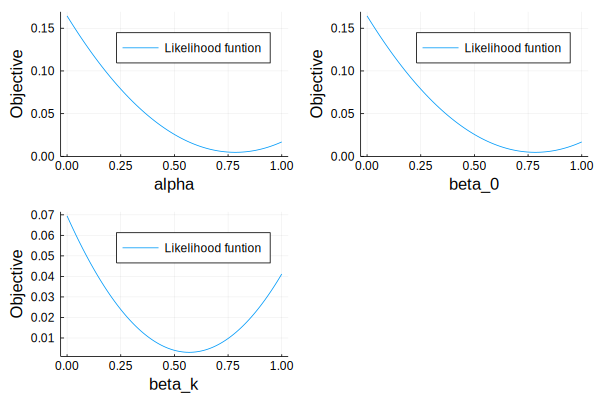

In [158]:
b_0 = range(0.0, 1.0, length = 100) 

value_b_0 = zeros(100)


for i in 1:100
    para = [b_0[i], 0.7, 0.7]
    value_b_0[i] =  objective_OP_2nd(para)
end



b_k = range(0.0, 1.0, length = 100) 
value_b_k = zeros(100)
for i in 1:100
    para = [1.0, b_k[i], 0.7]
    value_b_k[i] =  objective_OP_2nd(para)
end



a = range(0.0, 1.0, length = 100) 
value_a = zeros(100)
for i in 1:100
    para = [1.0, 0.7, a[i]]
    value_a[i] =  objective_OP_2nd(para)
end



beta_0 = plot(b_0, value, xlabel = "beta_0", ylabel = "Objective", label = "Likelihood funtion")
beta_k = plot(b_k, value_b_k, xlabel = "beta_k", ylabel = "Objective", label = "Likelihood funtion")
alpha = plot(a, value_a, xlabel = "alpha", ylabel = "Objective", label = "Likelihood funtion")

plot( alpha, beta_0, beta_k)

In [168]:
para_ini = zeros(3)
optimize(objective_OP_2nd, para_ini, LBFGS(), autodiff =:forward)

 * Status: success

 * Candidate solution
    Minimizer: [-4.18e-01, 1.70e+00, 6.00e-01]
    Minimum:   2.541768e-16

 * Found with
    Algorithm:     L-BFGS
    Initial Point: [0.00e+00, 0.00e+00, 0.00e+00]

 * Convergence measures
    |x - x'|               = 7.95e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.68e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.93e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.94e+05 ≰ 0.0e+00
    |g(x)|                 = 3.16e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    15
    f(x) calls:    51
    ∇f(x) calls:   51
